Columns in dataset:
Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Detected price column: price

Records after target cleaning: 21613
Records after outlier filter: 20467

Training Polynomial Regression...
Best polynomial degree: 2

=== Test Metrics (Dataset B) ===
                             Model           MAE           MSE           RMSE  \
0  Polynomial Regression Dataset B  72626.564721  1.005778e+10  100288.464281   

         R2  
0  0.758482  

Saved model files: condo_price_model_datasetB.pkl + model_columns_datasetB.pkl


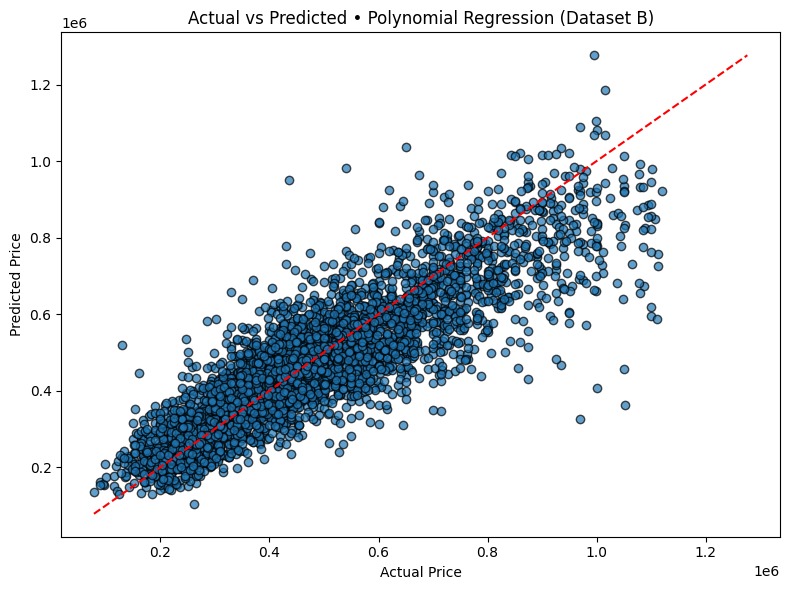


Polynomial Regression (Dataset B TEST):
Mean absolute error:  72626.56472098932
Mean squared error:   10057776067.744183
R2 score is:  0.7584822783746251

Polynomial Regression (Dataset B TRAIN):
Mean absolute error:  71874.09720381277
Mean squared error:   9675911911.143166
R2 score is:  0.7793741657181105


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# ---------- Helpers ----------
def evaluate_metrics(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def pretty_block(y_true, y_pred):
    print(f"Mean absolute error:  {mean_absolute_error(y_true, y_pred)}")
    print(f"Mean squared error:   {mean_squared_error(y_true, y_pred)}")
    print(f"R2 score is:  {r2_score(y_true, y_pred)}")

# ---------- Load Dataset ----------
df = pd.read_csv("Complete_Housing_set.csv")
df.columns = [c.strip() for c in df.columns]

print("Columns in dataset:")
print(df.columns)

# ---------- Auto-detect Target ----------
price_keywords = ["price", "cost", "amount", "value"]
target = None

for col in df.columns:
    if any(key in col.lower() for key in price_keywords):
        target = col
        break

if target is None:
    raise ValueError("❌ No price column found. Rename your column to include the word 'price'.")

print(f"\nDetected price column: {target}\n")

# ---------- Clean Target ----------
df[target] = (
    df[target].astype(str)
      .str.replace(",", "", regex=False)
      .str.replace("$", "", regex=False)
      .str.replace("USD", "", regex=False)
      .str.replace("THB", "", regex=False)
      .str.strip()
)

df[target] = pd.to_numeric(df[target], errors="coerce")
df.dropna(subset=[target], inplace=True)
print(f"Records after target cleaning: {len(df)}")

# ---------- Outlier Removal ----------
Q1, Q3 = df[target].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df_clean = df[(df[target] >= lower) & (df[target] <= upper)].copy()

if len(df_clean) == 0:
    df_clean = df.copy()

print(f"Records after outlier filter: {len(df_clean)}")

# ---------- Feature Selection ----------
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

if target in num_cols:
    num_cols.remove(target)

# ---------- FIX MISSING VALUES ----------
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].mean())

X = df_clean[num_cols].copy()
y = df_clean[target].copy()

# ---------- Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

y_train_log = np.log1p(y_train)
joblib.dump(X_train.mean().to_dict(), "X_train_mean_datasetB.pkl")

# ---------- Polynomial Regression Pipeline ----------
pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("model",  LinearRegression())
])

grid_poly = { "poly__degree": [1, 2, 3, 4] }

print("\nTraining Polynomial Regression...")
gs_poly = GridSearchCV(pipe_poly, grid_poly, cv=5, scoring="r2", n_jobs=-1)
gs_poly.fit(X_train, y_train_log)

best_model = gs_poly.best_estimator_
best_degree = gs_poly.best_params_["poly__degree"]

print(f"Best polynomial degree: {best_degree}")

# ---------- Evaluate ----------
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

m = evaluate_metrics(y_test, y_pred, "Polynomial Regression Dataset B")
metrics_df = pd.DataFrame([m])

print("\n=== Test Metrics (Dataset B) ===")
print(metrics_df)

metrics_df.to_csv("model_metrics_datasetB.csv", index=False)

# ---------- Save Model ----------
joblib.dump(best_model, "condo_price_model_datasetB.pkl")
joblib.dump(list(X_train.columns), "model_columns_datasetB.pkl")

print("\nSaved model files: condo_price_model_datasetB.pkl + model_columns_datasetB.pkl")

# ---------- Plot ----------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k")
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted • Polynomial Regression (Dataset B)")
plt.tight_layout()
plt.show()

# ---------- Pretty Output ----------
print("\nPolynomial Regression (Dataset B TEST):")
pretty_block(y_test, y_pred)

print("\nPolynomial Regression (Dataset B TRAIN):")
pretty_block(y_train, np.expm1(best_model.predict(X_train)))
